# PBCO historgram plot of all the modes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import pandas as pd
import tensorflow as tf
from importlib import reload
import alris_one_third_functions as alris_one_third_functions
reload(alris_one_third_functions)
from alris_one_third_functions import shift_atoms, transform_list_hkl_p63_p65, get_structure_factors , atom_position_list

number_of_modes = 1290

In [2]:
def fun_tf(hkl_list, pars, matrix):
    """
    Fast computation of structure factors with parameter-dependent structure.
    """

    # Get modified structure
    pars_tensor = tf.stack(pars)  # shape (params,)

    #t0 = time()
    atom_shift_list = shift_atoms(matrix , (pars_tensor))
    #print(f"atom_shift_list time: {time() - t0:.4f} seconds")
    atom_shift_list = atom_shift_list[:,0]

    atom_shift_list = tf.unstack(atom_shift_list)
    #convert atom_shift_list to a numpy array
    #t0 = time()
    modified_struct = atom_position_list(*atom_shift_list)
    #print(f"Time taken for atom_positionList: {time() - t0:.4f} seconds")
    
    hkl_list = transform_list_hkl_p63_p65(hkl_list)

    # Get structure factors

    sf_hkl = get_structure_factors(hkl_list, modified_struct)
    intensity = (abs(sf_hkl)) ** 2

    w = tf.constant(0.00032001553565274784, dtype=tf.float32)  # Debye-Waller factor 
    qnorms = tf.norm(tf.cast(hkl_list, tf.float32), axis=1)
    max_intensity = np.max(intensity)
    intensity = np.where(intensity < max_intensity * 0.05, tf.zeros_like(intensity), intensity)  # Ensure no negative intensities
    intensity = intensity * tf.exp(- w* qnorms ** 2)  # Apply Debye-Waller factor
    intensity = intensity / tf.reduce_max(intensity)
    intensity = intensity / tf.reduce_sum(intensity) * 60
    return intensity



In [11]:
def alris_r_factor(data):
    exp_intensity = data['intensity_exp'] / np.max(data['intensity_exp'])
    exp_intensity = exp_intensity / np.sum(exp_intensity) * 60
    simulated_intensity = data['intensity_sim']
    alris_r_factor = np.sum(np.abs(exp_intensity - simulated_intensity)) / np.sum(np.abs(exp_intensity))
    return alris_r_factor

def plot_plane_sim_vs_exp_DIM2(ax, df,r_factor, norm_plane=False):
    #only extract data for h == 0
    exp_data_0 = df.loc[df['k'] == 0].copy()
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['h'], exp_data_0['l'], 
               s=np.log10(exp_data_0['intensity_sim'] + 1) * 500 , color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o"))
    ax.scatter(exp_data_0['h'] , exp_data_0['l'] , s=np.log10(exp_data_0['intensity_exp'] + 1) * 500, color='blue', edgecolor="black",
                label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    # #grid on
    # ax.grid(True, linestyle='--', alpha=0.7)
    # #adjust x axis ticks
    # ax.set_xticks(np.arange(0, -5, 0.11))
    # ax.set_yticks(np.arange(0, 15, 0.11))
    ax.set_xlabel(f"h in (h, 0, l) [r.l.u.]")
    ax.set_ylabel(f"l in (h, 0, l) [r.l.u.]")
    ax.set_title(f"HL plane for K = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()
    # ax.set_xlim(0 , -5.01)
    # ax.set_ylim(-1.01 , 3)


def plot_plane_sim_vs_exp_DIM1(ax, df, r_factor, norm_plane=False):
    
    exp_data_0 = df.loc[df['h'] == 0].copy()
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['k'], exp_data_0['l'], 
               s=np.log10(exp_data_0['intensity_sim'] + 1)* 500 , color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o"))
    ax.scatter(exp_data_0['k'] , exp_data_0['l'] , s=np.log10(exp_data_0['intensity_exp'] + 1)* 500 , color='blue', edgecolor="black",
               label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    #grid on
    # ax.grid(True, linestyle='--', alpha=0.7)
    # #adjust x axis ticks
    # ax.set_xticks(np.arange(0, -5, 0.11))
    # ax.set_yticks(np.arange(0, 15, 0.11))
    ax.set_xlabel(f"k in (0, k, l) [r.l.u.]")
    ax.set_ylabel(f"l in (h, 0, l) [r.l.u.]")
    ax.set_title(f"KL plane for H = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()



def plot_plane_sim_vs_exp_DIM3(ax, df, r_factor, l,norm_plane=False):
    exp_data_0 = df.loc[df['l'] == 0].copy()
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['h'], exp_data_0['k'], 
            s=np.log10(exp_data_0['intensity_sim'] + 1)* 500 , color='red', edgecolor="black",
            label='Sim', marker=MarkerStyle("o"))
    ax.scatter(exp_data_0['h'] , exp_data_0['k'] , s=np.log10(exp_data_0['intensity_exp'] + 1)* 500 , color='blue', edgecolor="black",
            label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    #adjust x axis ticks
    # ax.set_xticks(np.arange(0, -5, 0.11))
    # ax.set_yticks(np.arange(0, -5, 0.11))
    ax.set_xlabel(f"h in (h, k, {l}) [r.l.u.]")
    ax.set_ylabel(f"k in (h, k, {l}) [r.l.u.]")
    ax.set_title(f"HK plane for L = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()

In [10]:
def calculate_structure_factor(iteration, histogram_matrix):
    exp_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/alrisDistortionFit/PBCO/PBCO_1_3/raw_data/1_3_LOGcombined_peaks.csv')
    n_features = exp_data.shape[0]
    n_dim = 3
    hkl_list = exp_data[["h", "k", "l"]].values.tolist()
    hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)
    features = hkl_list

    labels = exp_data["intensity_exp"].tolist()
    labels = labels / np.max(labels)  # Normalize labels
    labels = labels / np.sum(labels) * 60 # Normalize labels

    # #initialise
    best_model_pars = histogram_matrix[iteration, :]
    best_model_pars = tf.convert_to_tensor(best_model_pars, dtype=tf.float32)   

    matrix = np.loadtxt('C:/Users/User/Desktop/uzh_intern/alrisDistortionFit/PBCO/PBCO_1_3/1_3_matrix.txt', dtype=np.float32)
    #convert matrix to tensor
    matrix = tf.convert_to_tensor(matrix, dtype=tf.float32)
    exp_data['intensity_sim'] = fun_tf(features, best_model_pars , matrix).numpy()
    

    r_factor = alris_r_factor(exp_data)
    print(f"ALRIS R-factor: {r_factor:.3f}")

    return exp_data, r_factor


(156, 2000)
Minimum loss index: 527
Minimum loss value: 0.938
ALRIS R-factor: 0.736
R-factor: 0.736


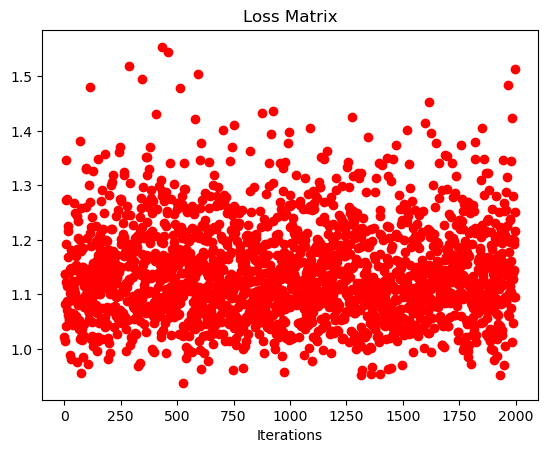

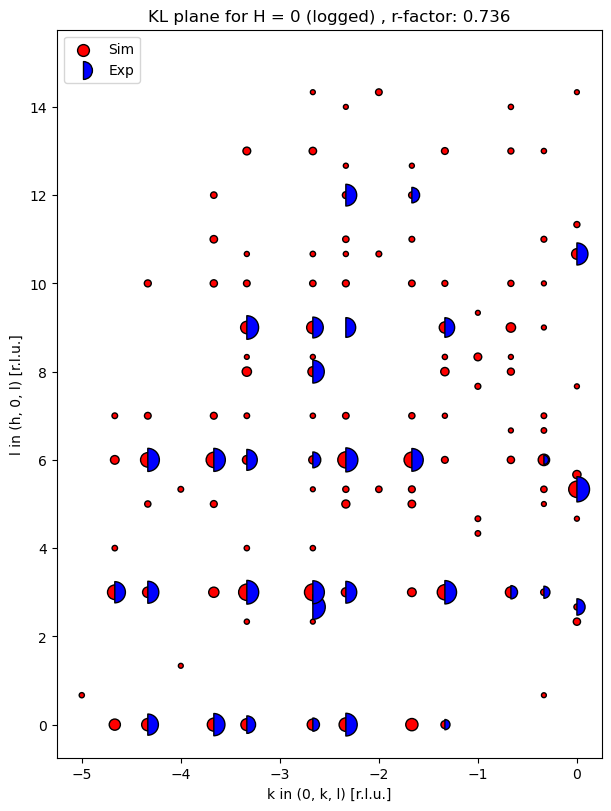

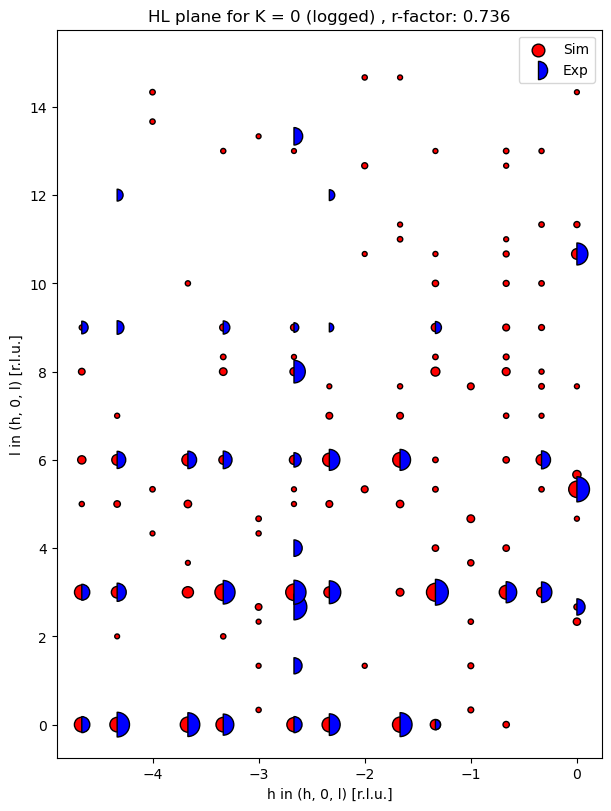

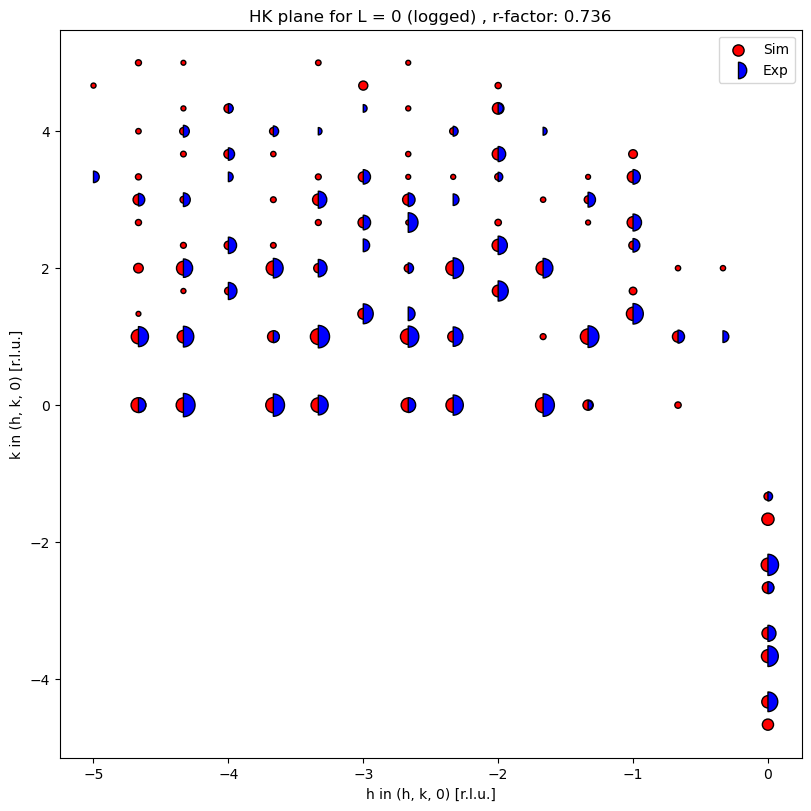

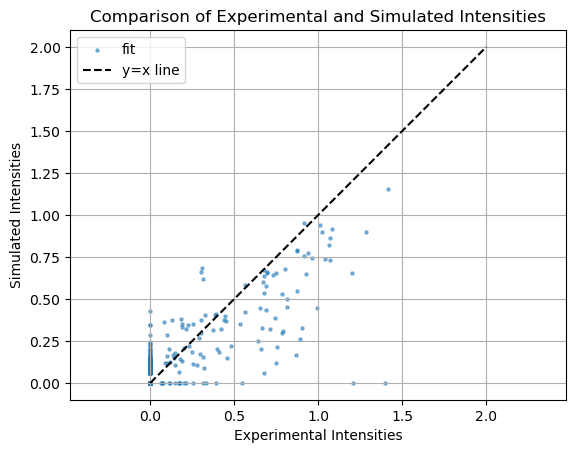

In [12]:
#load file 
number_of_modes = 156
histogram = np.load('C:/Users/User/Desktop/uzh_intern/alrisDistortionFit/PBCO/PBCO_1_3/results/LOG20250831_074654_iters2000_epochs75_lr0.08/all_result_matrix.npz')

#extact histogram matrix
histogram_matrix = histogram['histogram_matrix'] # [modes , iterations]
print(histogram_matrix.shape)

hist_matrix = histogram_matrix.T #[iterations, modes]



loss_matrix = histogram['loss_matrix']
r_factors = histogram['r_factors']
iteration = np.arange(0, len(loss_matrix))


plt.scatter(iteration,loss_matrix, label='Loss over iterations', color='red')
plt.title('Loss Matrix')
plt.xlabel('Iterations')

#extract iterations where the loss matrix is less than a certain threshold
threshold = 0.15
filtered_iterations = iteration[loss_matrix < threshold]

# Plot the filtered loss values
plt.scatter(filtered_iterations, loss_matrix[loss_matrix < threshold], label='Filtered Loss', color='blue')

#find the index where the min loss matrix value is
min_loss_index = np.argmin(loss_matrix)
print(f"Minimum loss index: {min_loss_index}")
print(f"Minimum loss value: {loss_matrix[min_loss_index]:.3f}") 

exp_data , r_factor = calculate_structure_factor(min_loss_index, hist_matrix)
print(f"R-factor: {r_factor:.3f}")

fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM1(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM2(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM3(axs, exp_data, r_factor, 0,norm_plane=True)
plt.show()

x = np.linspace(0 ,2, 100)
y = x
plt.scatter(exp_data['intensity_exp']/np.sum(exp_data['intensity_exp']) * 60, exp_data['intensity_sim'], s=5, alpha=0.5 , label='fit')
plt.plot(x , y, color='black', linestyle='--', label='y=x line')
plt.legend()
plt.grid(True)
plt.title('Comparison of Experimental and Simulated Intensities')
plt.xlabel('Experimental Intensities')
plt.ylabel('Simulated Intensities')
plt.axis('equal')
plt.show()

(1290, 100)
[[-2.2104585   2.8094478  -0.30341077 ... -0.64281523 -2.9876943
   0.8274677 ]
 [ 3.097396    4.5168204   0.8074764  ...  2.4535043  -2.2539852
   4.773432  ]
 [-0.8318444  -1.1158442  -1.2382679  ...  1.1208146  -0.10607056
   2.746911  ]
 ...
 [-1.1015441   2.4732928   2.1218808  ...  0.0700028  -0.8773983
  -0.71581966]
 [-2.4149253   1.2059246  -3.2917616  ...  1.6297094  -2.274576
  -3.002759  ]
 [-0.05599775 -0.02340081 -0.5420105  ... -1.7874604   0.16252433
  -1.1311364 ]]
ALRIS R-factor: 1.863


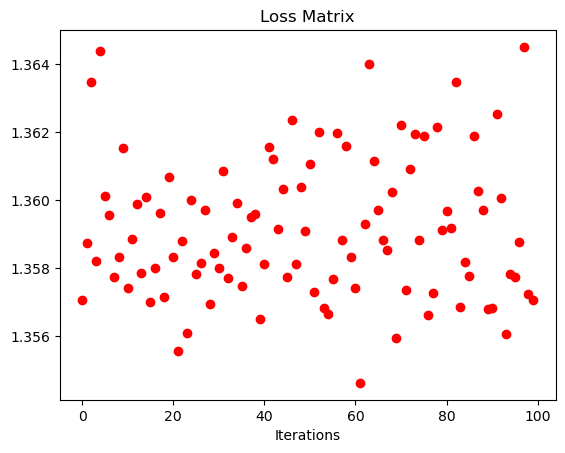

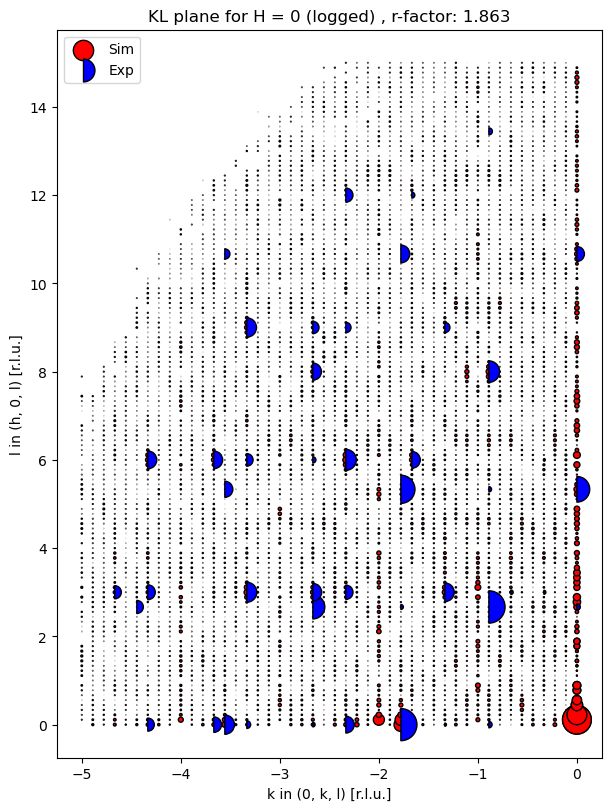

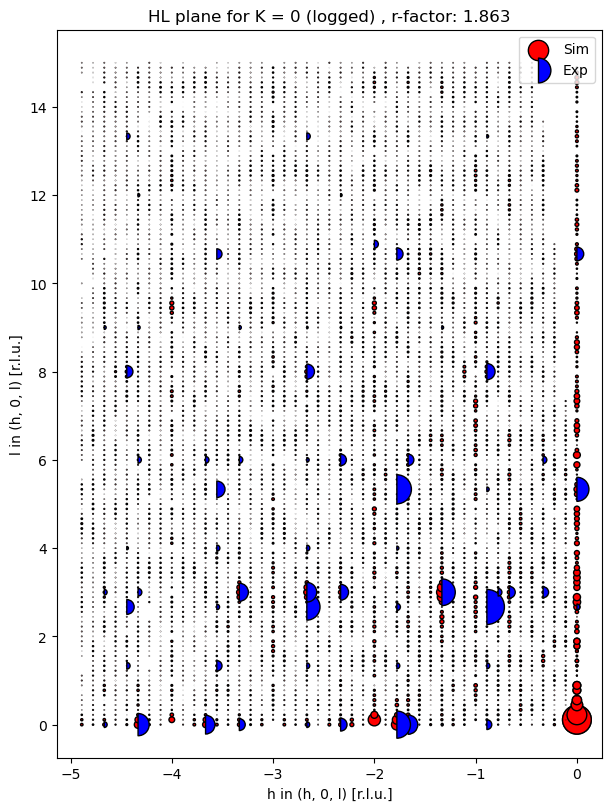

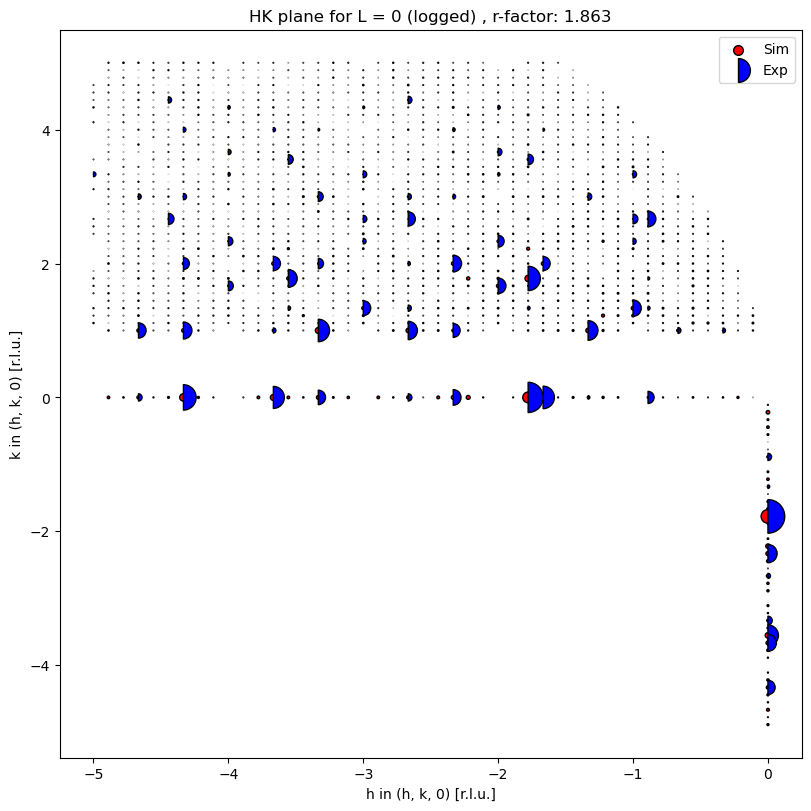

In [8]:
histogram = np.load("C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/results/20250808_144243_iters100_epochs50_lr0.1/all_result_matrix.npz")


#extact histogram matrix
histogram_matrix = histogram['histogram_matrix']
print(histogram_matrix.shape)
print(histogram_matrix)

histogram_matrix = histogram_matrix.T

loss_matrix = histogram['loss_matrix']

iteration = np.arange(0, len(loss_matrix))


plt.scatter(iteration,loss_matrix, label='Loss over iterations', color='red')
plt.title('Loss Matrix')
plt.xlabel('Iterations')

#extract iterations where the loss matrix is less than a certain threshold
threshold = 0.15
filtered_iterations = iteration[loss_matrix < threshold]

# Plot the filtered loss values
plt.scatter(filtered_iterations, loss_matrix[loss_matrix < threshold], label='Filtered Loss', color='blue')

#find the index where the min loss matrix value is
min_loss_index = np.argmin(loss_matrix)

exp_data , r_factor = calculate_structure_factor(min_loss_index, histogram_matrix)

fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM1(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM2(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM3(axs, exp_data, r_factor, 0,norm_plane=True)
plt.show()


(1290, 100)
[[-1.9734551   0.46571848 -1.6578946  ...  2.5028634   1.8256413
  -4.089955  ]
 [-2.146991   -0.20358528 -0.41932046 ... -0.20827092  2.8212025
  -0.9334925 ]
 [ 1.6542519   1.0153708   0.17184755 ... -1.6089864  -2.5722508
  -1.4106135 ]
 ...
 [-1.6568372  -2.1494095  -0.12370161 ...  0.22169669  2.3929563
  -0.07255768]
 [ 4.6752295  -0.30227795 -0.6502767  ...  0.04181373  2.5851128
  -2.9339125 ]
 [ 1.5246856  -3.2824266   1.1977466  ...  0.87581056  1.1432306
  -2.9269197 ]]
ALRIS R-factor: 1.874


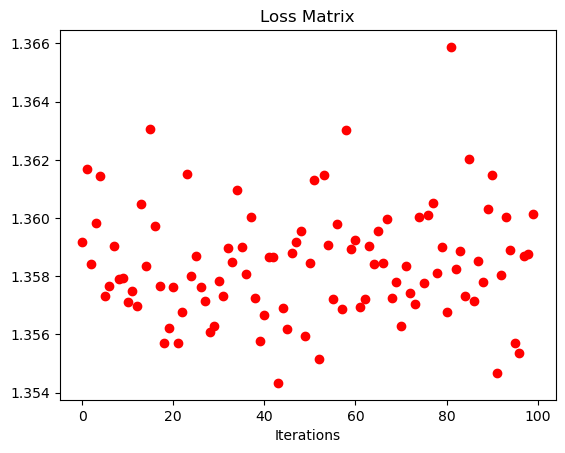

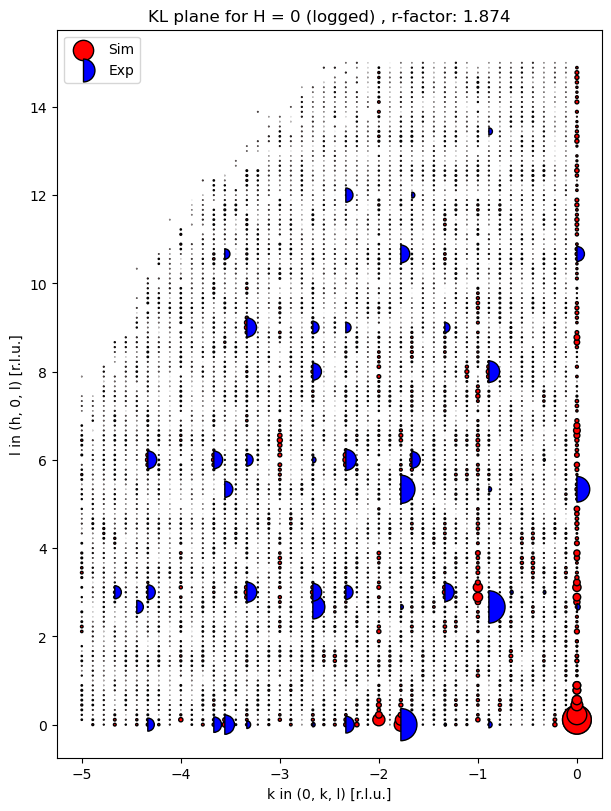

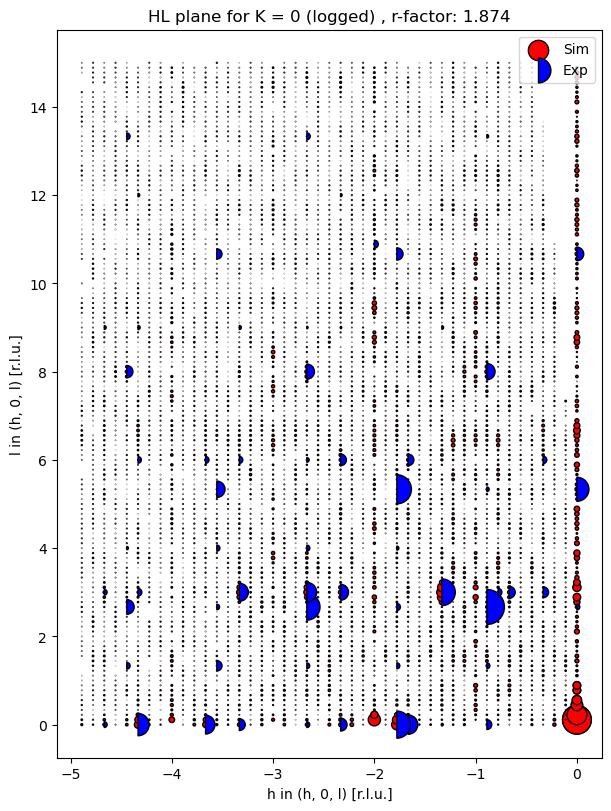

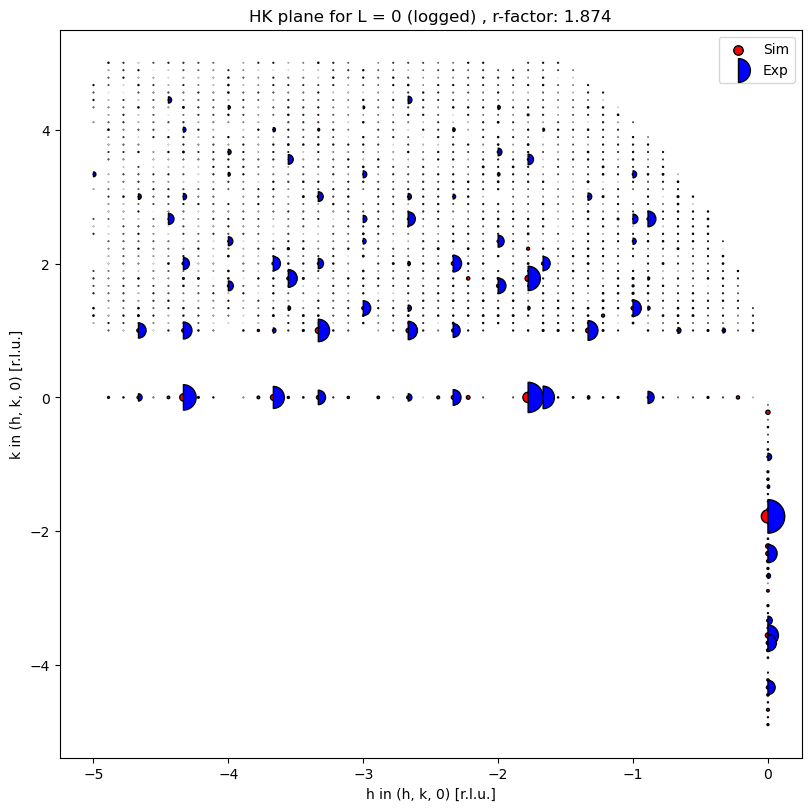

In [9]:
histogram = np.load("C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/results/20250808_153802_iters100_epochs50_lr0.1/all_result_matrix.npz")


#extact histogram matrix
histogram_matrix = histogram['histogram_matrix']
print(histogram_matrix.shape)
print(histogram_matrix)

histogram_matrix = histogram_matrix.T

loss_matrix = histogram['loss_matrix']

iteration = np.arange(0, len(loss_matrix))


plt.scatter(iteration,loss_matrix, label='Loss over iterations', color='red')
plt.title('Loss Matrix')
plt.xlabel('Iterations')

#extract iterations where the loss matrix is less than a certain threshold
threshold = 0.15
filtered_iterations = iteration[loss_matrix < threshold]

# Plot the filtered loss values
plt.scatter(filtered_iterations, loss_matrix[loss_matrix < threshold], label='Filtered Loss', color='blue')

#find the index where the min loss matrix value is
min_loss_index = np.argmin(loss_matrix)

exp_data , r_factor = calculate_structure_factor(min_loss_index, histogram_matrix)

fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM1(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM2(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM3(axs, exp_data, r_factor, 0,norm_plane=True)
plt.show()


(1290, 100)
[[-1.9751891  -0.08538965  0.54876614 ... -2.0546644   1.7187219
  -0.11568909]
 [-0.06968829  1.7490222  -0.02466305 ...  1.1291188  -2.4846468
  -3.207832  ]
 [ 1.3151468   0.01199292 -0.9050714  ... -1.7412515   0.33816025
  -2.030229  ]
 ...
 [-0.14626756 -2.9880838  -2.3138046  ...  2.2013774  -0.46076807
   3.0556183 ]
 [-2.5924025   3.318484   -1.9179668  ...  0.80960613  2.390867
   1.0595953 ]
 [ 0.08587229  4.439591    4.5089903  ... -2.3180814  -3.6614525
   2.740745  ]]
ALRIS R-factor: 1.839
R-factor: 1.839


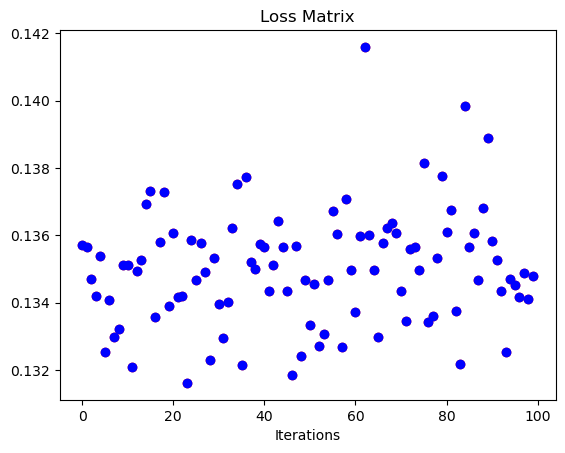

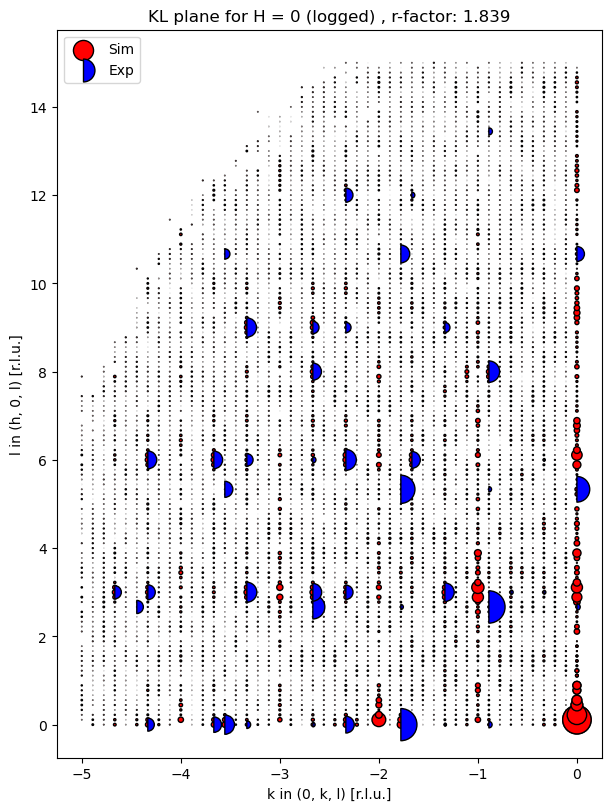

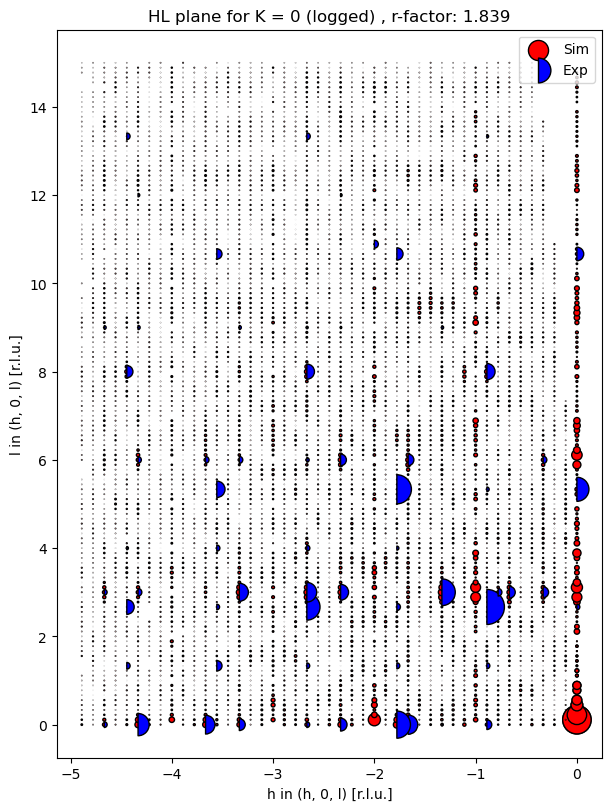

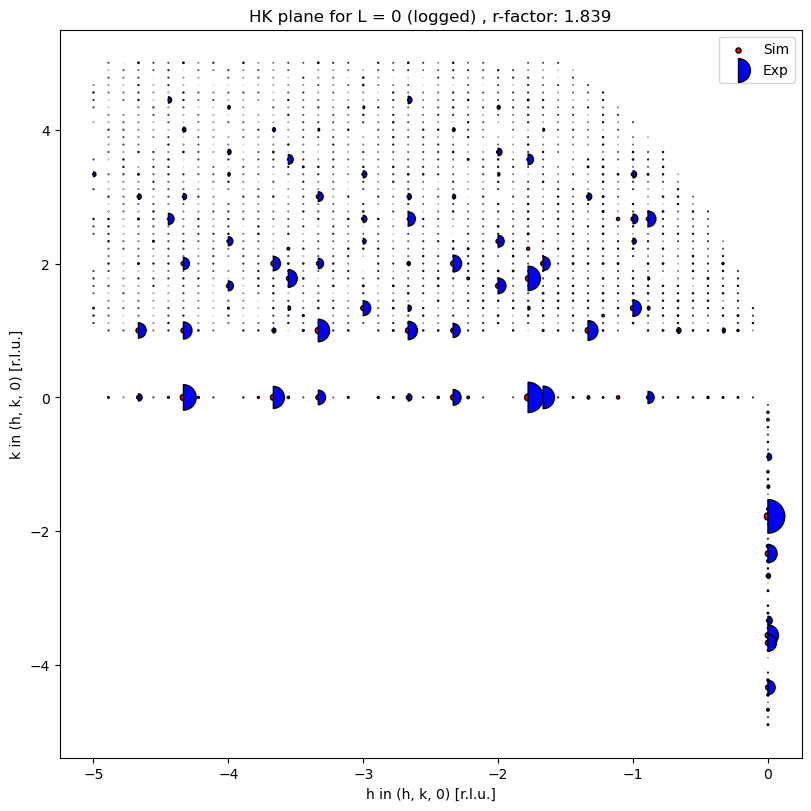

In [ ]:
histogram = np.load("C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/results/LOG20250808_154331_iters100_epochs50_lr0.1/all_result_matrix.npz")


#extact histogram matrix
histogram_matrix = histogram['histogram_matrix']
print(histogram_matrix.shape)
print(histogram_matrix)

histogram_matrix = histogram_matrix.T

loss_matrix = histogram['loss_matrix']

iteration = np.arange(0, len(loss_matrix))


plt.scatter(iteration,loss_matrix, label='Loss over iterations', color='red')
plt.title('Loss Matrix')
plt.xlabel('Iterations')

#extract iterations where the loss matrix is less than a certain threshold
threshold = 0.15
filtered_iterations = iteration[loss_matrix < threshold]

# Plot the filtered loss values
plt.scatter(filtered_iterations, loss_matrix[loss_matrix < threshold], label='Filtered Loss', color='blue')

#find the index where the min loss matrix value is
min_loss_index = np.argmin(loss_matrix)

exp_data , r_factor = calculate_structure_factor(min_loss_index, histogram_matrix)
print(f"R-factor: {r_factor:.3f}")

fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM1(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM2(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM3(axs, exp_data, r_factor, 0,norm_plane=True)
plt.show()


(1290, 32)
[[-2.0471652e+00 -3.5905290e-02  2.8630495e+00 ... -1.7347797e+00
   8.4134144e-01  2.9859056e+00]
 [-2.3303044e+00  3.3412828e+00  1.1200693e+00 ... -6.0217458e-01
  -2.2931278e-01 -1.4795764e-01]
 [ 1.4876187e+00 -1.7212290e+00 -4.2971606e+00 ...  4.9165916e-02
  -3.2552314e-01 -9.8500979e-01]
 ...
 [-1.2704608e+00  2.8350053e+00 -2.7181427e+00 ... -3.9957073e-01
  -5.6973863e-01  1.0081707e+00]
 [ 2.9169948e+00  7.4228650e-01 -1.1219863e+00 ... -1.6663657e-03
   3.4474537e-01  3.8707659e-01]
 [ 2.0427902e+00  2.1740255e-01 -2.1880202e+00 ...  1.4928150e+00
   4.8318601e-01 -9.3651903e-01]]


NameError: name 'alris_r_factor' is not defined

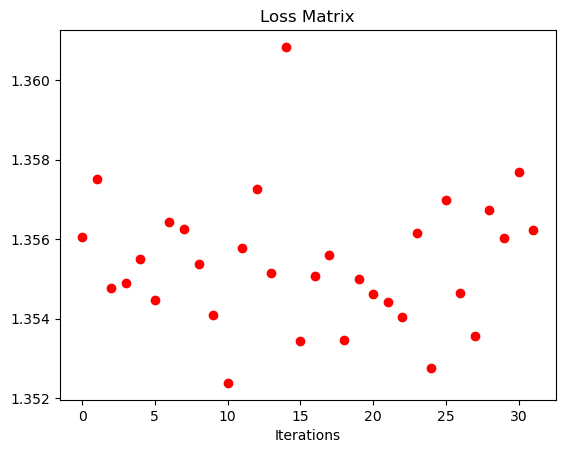

In [9]:


histogram = np.load("C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/results/20250808_165523_iters32_epochs100_lr0.1/all_result_matrix.npz")


#extact histogram matrix
histogram_matrix = histogram['histogram_matrix']
print(histogram_matrix.shape)
print(histogram_matrix)

histogram_matrix = histogram_matrix.T

loss_matrix = histogram['loss_matrix']
r_factors = histogram['r_factors']
iteration = np.arange(0, len(loss_matrix))


plt.scatter(iteration,loss_matrix, label='Loss over iterations', color='red')
plt.title('Loss Matrix')
plt.xlabel('Iterations')

#extract iterations where the loss matrix is less than a certain threshold
threshold = 0.15
filtered_iterations = iteration[loss_matrix < threshold]

# Plot the filtered loss values
plt.scatter(filtered_iterations, loss_matrix[loss_matrix < threshold], label='Filtered Loss', color='blue')

#find the index where the min loss matrix value is
min_r_index = np.argmin(r_factors)

exp_data , r_factor = calculate_structure_factor(min_r_index, histogram_matrix)
print(f"R-factor: {r_factor:.3f}")

fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM1(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM2(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM3(axs, exp_data, r_factor, 0,norm_plane=True)
plt.show()


In [3]:

histogram = np.load("C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/results/20250809_185441_iters20000_epochs50_lr0.1/all_result_matrix.npz")


#extact histogram matrix
histogram_matrix = histogram['histogram_matrix']
print(histogram_matrix.shape)
print(histogram_matrix)

histogram_matrix = histogram_matrix.T

(1290, 20000)
[[ 3.7013714   2.438303   -4.185316   ...  1.1781211  -0.06485258
   0.15346435]
 [ 4.0869517  -4.946145    1.4661826  ... -0.48781368 -0.9718179
   2.1457822 ]
 [-0.3593831   4.350437    3.8639386  ... -0.83925265 -1.2311713
   1.0663044 ]
 ...
 [-0.60998625 -3.5127208  -2.1978045  ...  2.057068   -2.221308
  -2.4686215 ]
 [ 1.9583943   4.881805    4.10192    ... -1.6107451   3.1039364
  -5.647977  ]
 [-2.4311423   3.5848193  -0.9403799  ...  2.6673064   0.7178208
   2.2455175 ]]


(1290, 10000)
[[ 0.         -0.          0.         ... -0.         -0.
   0.        ]
 [ 0.         -0.         -0.         ...  0.          0.
  -0.        ]
 [ 0.          0.          0.         ... -0.         -0.
   0.        ]
 ...
 [ 0.         -0.          0.         ... -0.          0.
  -0.        ]
 [ 1.0209652   5.2785745  -2.1741061  ...  1.188385    3.2885754
   1.5928977 ]
 [ 3.2816043  -4.1863036   1.3589457  ...  0.91748166 -0.34099156
  -3.505052  ]]
ALRIS R-factor: 1.273
R-factor: 1.273


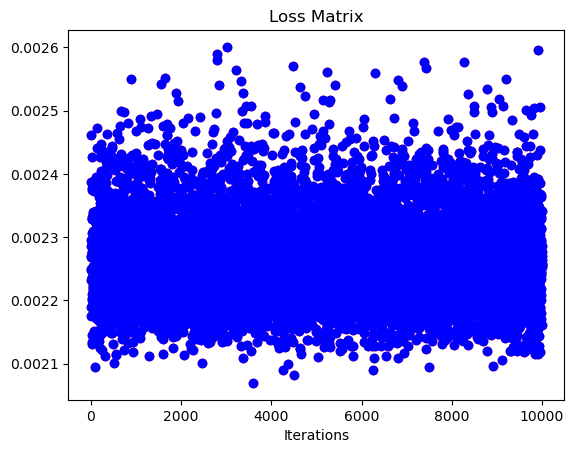

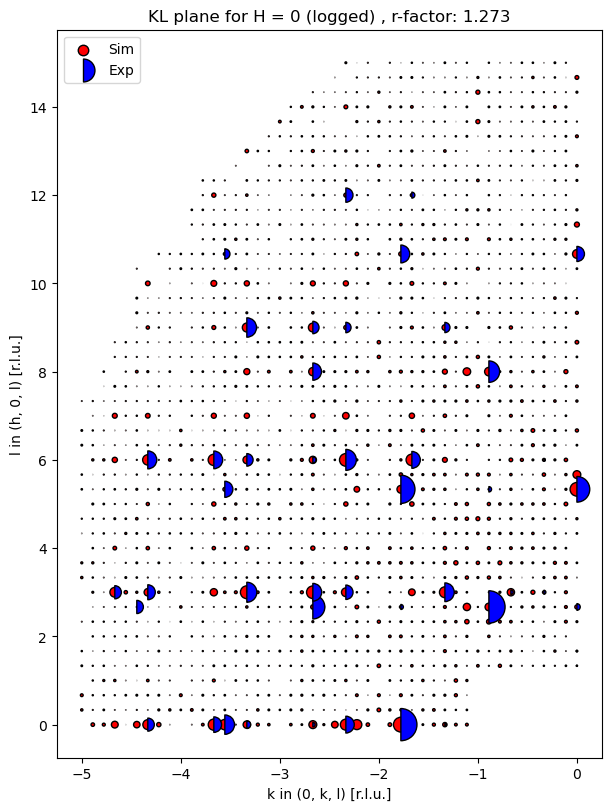

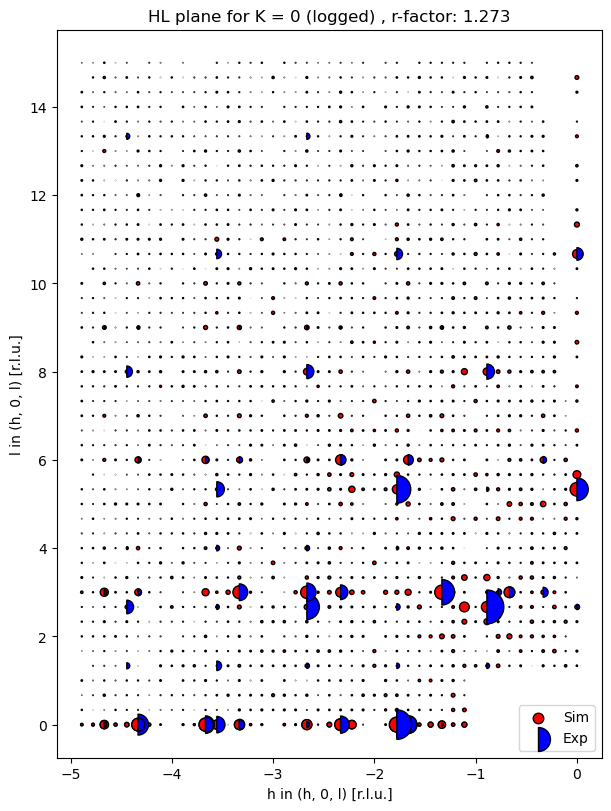

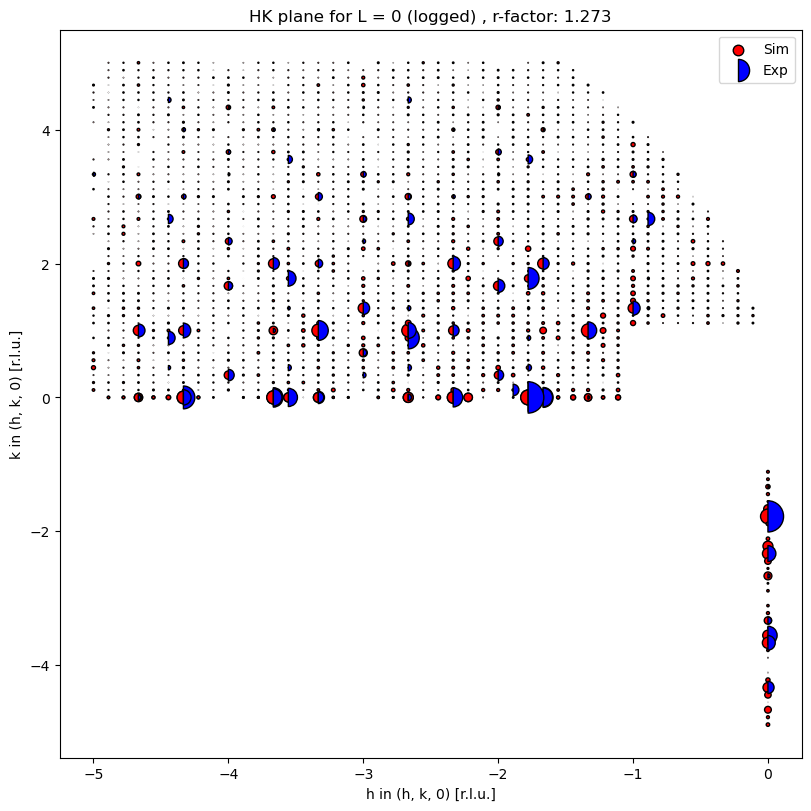

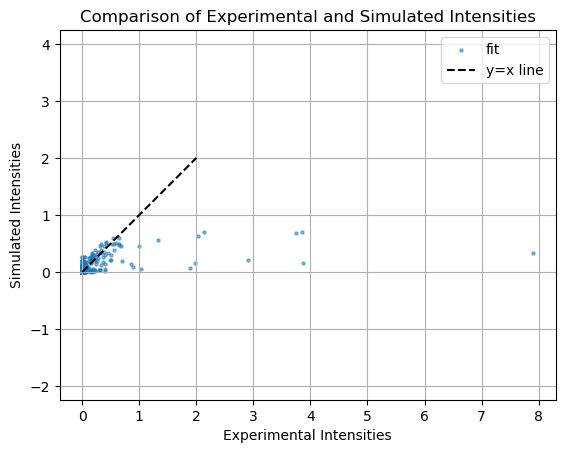

In [12]:
histogram = np.load("C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/results/LOG20250812_023843_iters10000_epochs50_lr0.1/all_result_matrix.npz")


#extact histogram matrix
histogram_matrix = histogram['histogram_matrix']
print(histogram_matrix.shape)
print(histogram_matrix)

histogram_matrix = histogram_matrix.T


loss_matrix = histogram['loss_matrix']
r_factors = histogram['r_factors']
iteration = np.arange(0, len(loss_matrix))


plt.scatter(iteration,loss_matrix, label='Loss over iterations', color='red')
plt.title('Loss Matrix')
plt.xlabel('Iterations')

#extract iterations where the loss matrix is less than a certain threshold
threshold = 0.15
filtered_iterations = iteration[loss_matrix < threshold]

# Plot the filtered loss values
plt.scatter(filtered_iterations, loss_matrix[loss_matrix < threshold], label='Filtered Loss', color='blue')

#find the index where the min loss matrix value is
min_r_index = np.argmin(loss_matrix)

exp_data , r_factor = calculate_structure_factor(min_r_index, histogram_matrix)
print(f"R-factor: {r_factor:.3f}")

fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM1(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM2(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM3(axs, exp_data, r_factor, 0,norm_plane=True)
plt.show()

x = np.linspace(0 ,2, 100)
y = x
plt.scatter(exp_data['intensity_exp']/np.sum(exp_data['intensity_exp']) * 60, exp_data['intensity_sim'], s=5, alpha=0.5 , label='fit')
plt.plot(x , y, color='black', linestyle='--', label='y=x line')
plt.legend()
plt.grid(True)
plt.title('Comparison of Experimental and Simulated Intensities')
plt.xlabel('Experimental Intensities')
plt.ylabel('Simulated Intensities')
plt.axis('equal')
plt.show()

# export histogram as mat file
import scipy.io as sio
sio.savemat('C:/Users/User/Desktop/uzh_intern/CrystalClearFit/alrisDistortionFit/PBCO/results/LOG20250812_023843_iters10000_epochs50_lr0.1/histogram_matrix.mat', {'histogram_matrix': histogram_matrix})


(1290, 7000)
[[ 0.         -0.         -0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.         ...  0.         -0.
   0.        ]
 [-0.          0.         -0.         ...  0.         -0.
   0.        ]
 ...
 [-0.          0.          0.         ... -0.         -0.
  -0.        ]
 [-4.2705474  -5.4221272  -2.9196093  ...  0.04929294  5.3927817
  -3.8579166 ]
 [ 5.3318343  -1.047818    0.33064336 ... -1.8350886   1.9290459
  -7.7871804 ]]
Minimum loss index: 6396
Minimum loss value: 0.489
ALRIS R-factor: 1.467
R-factor: 1.467


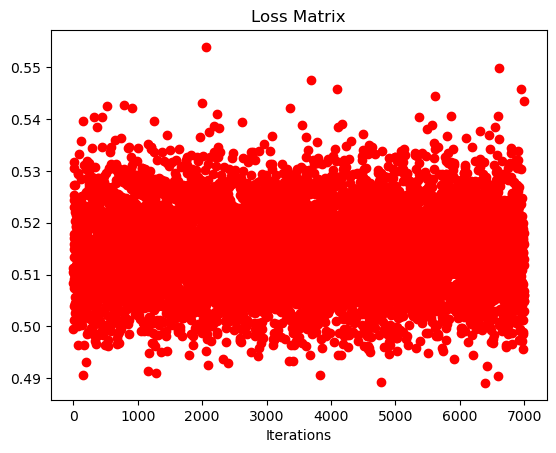

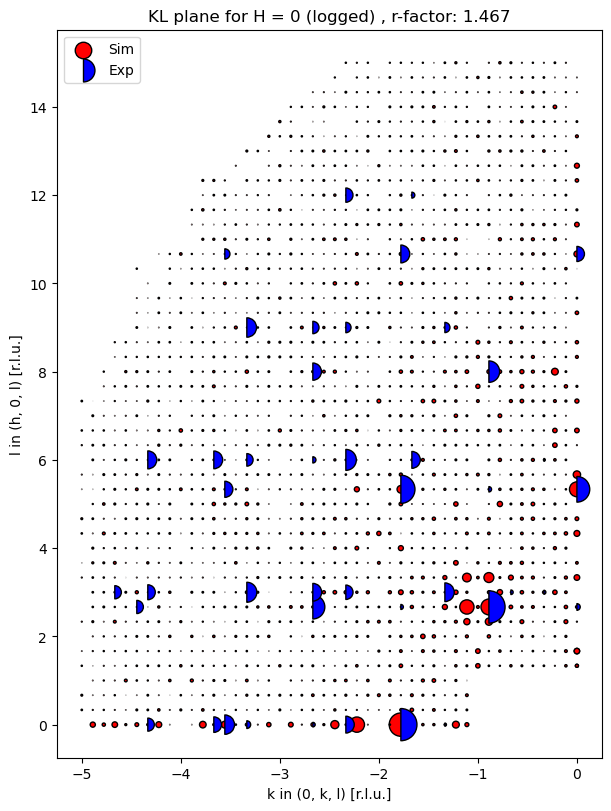

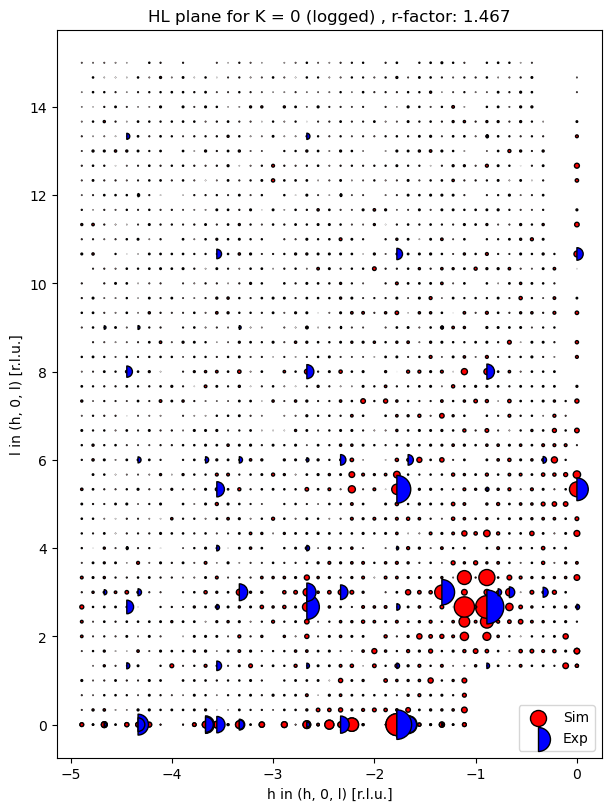

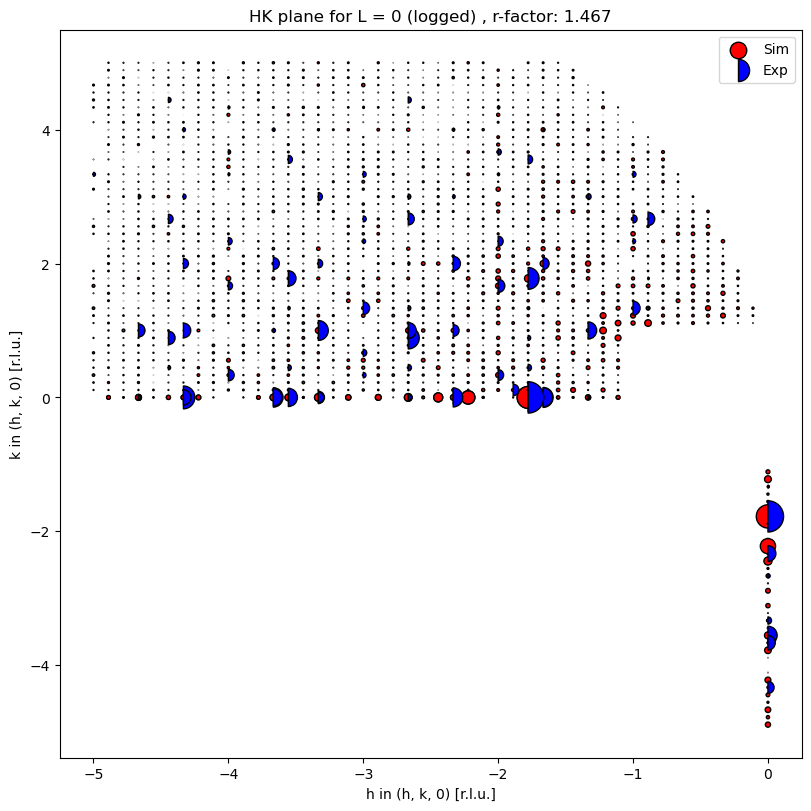

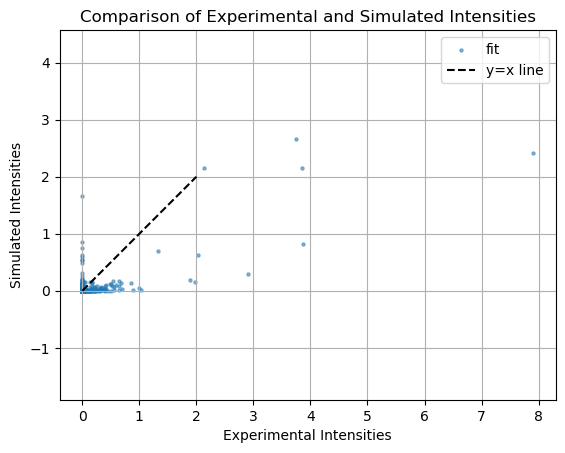

In [10]:

histogram = np.load("C:/Users/User/Desktop/uzh_intern/alrisDistortionFit/PBCO/results/20250812_231021_iters7000_epochs75_lr0.1/all_result_matrix.npz")


#extact histogram matrix
histogram_matrix = histogram['histogram_matrix']
print(histogram_matrix.shape)
print(histogram_matrix)

histogram_matrix = histogram_matrix.T


loss_matrix = histogram['loss_matrix']
r_factors = histogram['r_factors']
iteration = np.arange(0, len(loss_matrix))


plt.scatter(iteration,loss_matrix, label='Loss over iterations', color='red')
plt.title('Loss Matrix')
plt.xlabel('Iterations')

#extract iterations where the loss matrix is less than a certain threshold
threshold = 0.15
filtered_iterations = iteration[loss_matrix < threshold]

# Plot the filtered loss values
plt.scatter(filtered_iterations, loss_matrix[loss_matrix < threshold], label='Filtered Loss', color='blue')

#find the index where the min loss matrix value is
min_loss_index = np.argmin(loss_matrix)
print(f"Minimum loss index: {min_loss_index}")
print(f"Minimum loss value: {loss_matrix[min_loss_index]:.3f}") 

exp_data , r_factor = calculate_structure_factor(min_loss_index, histogram_matrix)
print(f"R-factor: {r_factor:.3f}")

fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM1(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM2(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM3(axs, exp_data, r_factor, 0,norm_plane=True)
plt.show()

x = np.linspace(0 ,2, 100)
y = x
plt.scatter(exp_data['intensity_exp']/np.sum(exp_data['intensity_exp']) * 60, exp_data['intensity_sim'], s=5, alpha=0.5 , label='fit')
plt.plot(x , y, color='black', linestyle='--', label='y=x line')
plt.legend()
plt.grid(True)
plt.title('Comparison of Experimental and Simulated Intensities')
plt.xlabel('Experimental Intensities')
plt.ylabel('Simulated Intensities')
plt.axis('equal')
plt.show()

# export histogram as mat file
import scipy.io as sio
sio.savemat('C:/Users/User/Desktop/uzh_intern/alrisDistortionFit/PBCO/results/20250812_231021_iters7000_epochs75_lr0.1/histogram_matrix.mat', {'histogram_matrix': histogram_matrix})


(1290, 15000)
[[-0.27764946 -0.16863684  0.5691258  ...  3.0007355   3.5123358
   0.50865644]
 [ 0.5160876  -5.291912   -4.9067807  ... -4.9910703   0.51404303
   0.6872984 ]
 [ 3.0436502   0.28203136  1.4263272  ...  2.8909252   3.2369676
  -2.3095071 ]
 ...
 [-3.4461331   1.1258005  -0.28357524 ...  5.5219913  -0.96718806
  -1.5486523 ]
 [-2.9245813   0.5497278   8.30927    ...  3.249845   -5.7161317
  -2.2737832 ]
 [ 7.04553     1.1613022   4.0323772  ...  0.89446604 -3.8506052
  -0.76326156]]
Minimum loss index: 12712
Minimum loss value: 0.029
Minimum R-factor index: 10587
Minimum R-factor value: 0.548
ALRIS R-factor: 0.557
R-factor: 0.557


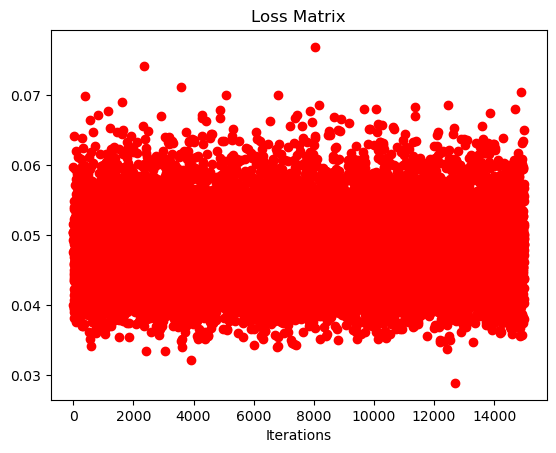

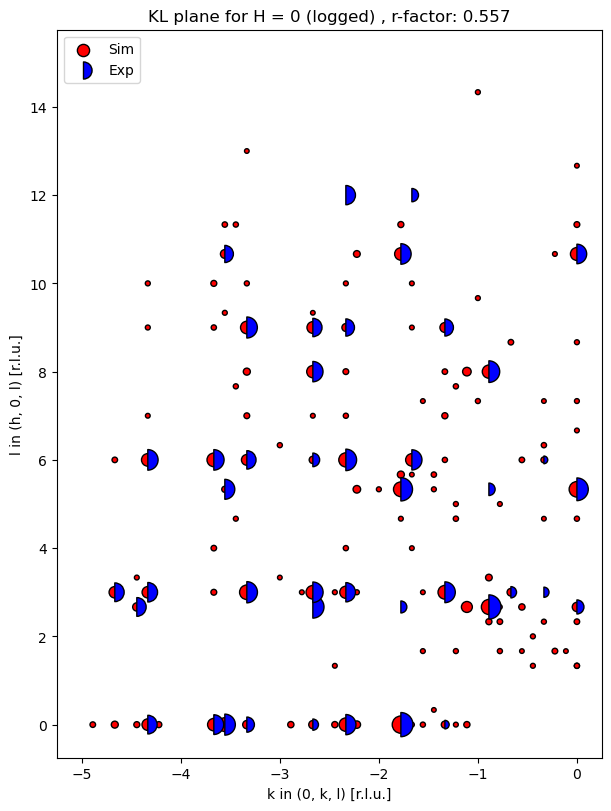

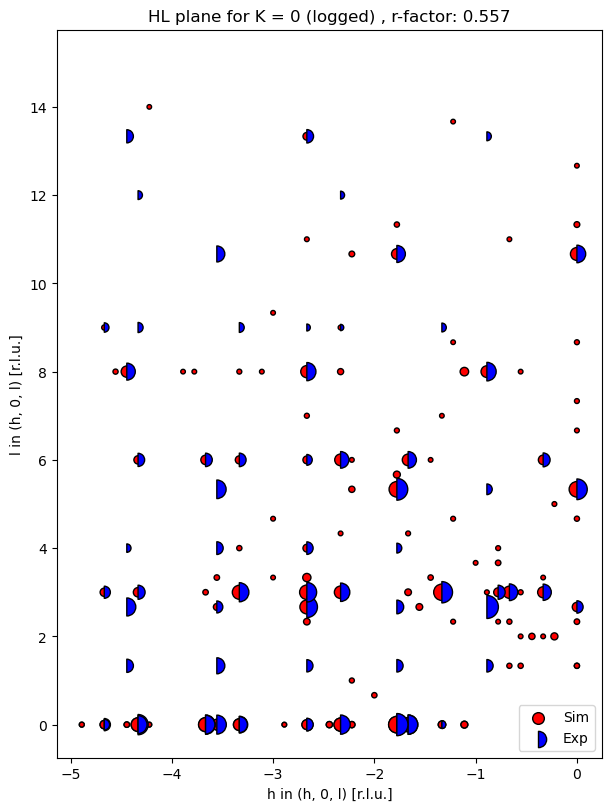

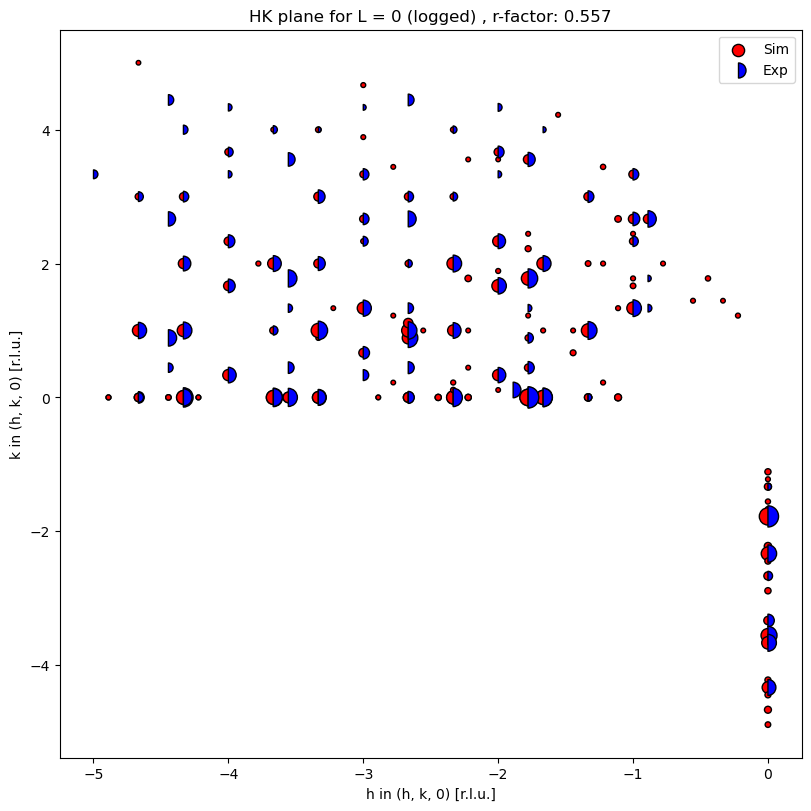

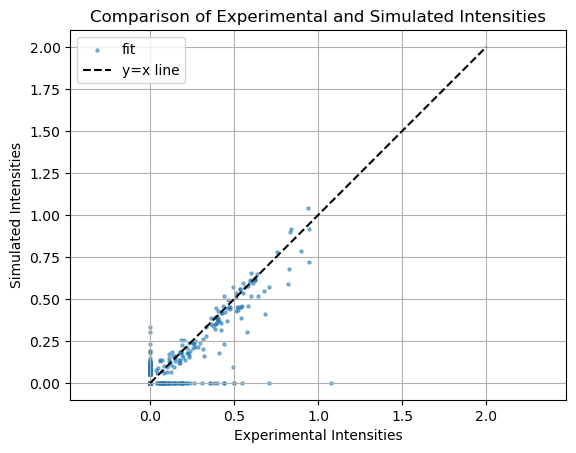

In [24]:
histogram = np.load("C:/Users/User/Desktop/uzh_intern/alrisDistortionFit/PBCO/results/LOG20250815_081950_iters15000_epochs75_lr0.1/all_result_matrix.npz")


#extact histogram matrix
histogram_matrix = histogram['histogram_matrix']
print(histogram_matrix.shape)
print(histogram_matrix)

histogram_matrix = histogram_matrix.T


loss_matrix = histogram['loss_matrix']
r_factors = histogram['r_factors']
iteration = np.arange(0, len(loss_matrix))


plt.scatter(iteration,loss_matrix, label='Loss over iterations', color='red')
plt.title('Loss Matrix')
plt.xlabel('Iterations')

#find the index where the min loss matrix value is
min_loss_index = np.argmin(loss_matrix)
print(f"Minimum loss index: {min_loss_index}")
print(f"Minimum loss value: {loss_matrix[min_loss_index]:.3f}") 

min_r_factor_index = np.argmin(r_factors)
print(f"Minimum R-factor index: {min_r_factor_index}")
print(f"Minimum R-factor value: {r_factors[min_r_factor_index]:.3f}")

exp_data , r_factor = calculate_structure_factor(min_r_factor_index, histogram_matrix)
print(f"R-factor: {r_factor:.3f}")

fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM1(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM2(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM3(axs, exp_data, r_factor, 0,norm_plane=True)
plt.show()

x = np.linspace(0 ,2, 100)
y = x
plt.scatter(exp_data['intensity_exp']/np.sum(exp_data['intensity_exp']) * 60, exp_data['intensity_sim'], s=5, alpha=0.5 , label='fit')
plt.plot(x , y, color='black', linestyle='--', label='y=x line')
plt.legend()
plt.grid(True)
plt.title('Comparison of Experimental and Simulated Intensities')
plt.xlabel('Experimental Intensities')
plt.ylabel('Simulated Intensities')
plt.axis('equal')
plt.show()

# export histogram as mat file
import scipy.io as sio
sio.savemat('C:/Users/User/Desktop/uzh_intern/alrisDistortionFit/PBCO/results/20250812_231021_iters7000_epochs75_lr0.1/histogram_matrix.mat', {'histogram_matrix': histogram_matrix})
